In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
import pydotplus
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import h5py
import skimage

from skimage import data
from skimage.color import rgb2gray, rgb2lab, lab2rgb
from skimage.transform import resize
from tensorflow.keras.callbacks import LambdaCallback

bin_weights = np.load('ab_space_weights.npy')
bin_weights = 20. * bin_weights

class CIFAR10Sequence(tf.keras.utils.Sequence):  # This should actually work for arbitrary size images as well.
    def __init__(self, x_set, y_set, batch_size=32):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        return batch_x, batch_y

#Own Callback class to
"""
class CallbackIntermediateRes(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch % save_rate is 0:
            pred = (prob_to_color(self.model.predict(Xtrain[4, :].reshape((1, Xtrain.shape[1], Xtrain.shape[2], 1)))))
            #pred = ((self.model.predict(Xtrain[4, :].reshape((1, Xtrain.shape[1], Xtrain.shape[2], 1)))) * 255 - 128)
            output = np.empty((Xtrain.shape[1], Xtrain.shape[2], 3))
            output[:, :, 0] = ((Xtrain[4, :, :]) * 100)  # the light channel.
            #
            output[:, :, 1] = pred[0, :, :, 0]
            output[:, :, 2] = pred[0, :, :, 1]
            rgb_out = lab2rgb(output)
            name = "intermediate_"+str(epoch)+".png"
            skimage.io.imsave(name, rgb_out)
"""

"""Read data and convert to grayscale"""
def load_images(filename):
    import pickle
    with open(filename, 'rb') as f:
        dataset = pickle.load(f, encoding='latin1')  # Nxd(3072) (Nx (32x32x3))
        img_data = dataset['data']
        #images = img_data.reshape(img_data.shape[0], 3, 32, 32).transpose(0, 2, 3, 1).astype('uint8')
        return img_data

def load_all():
    img1 = load_images('cifar-10-batches-py/data_batch_1')
    img2 = load_images('cifar-10-batches-py/data_batch_2')
    img3 = load_images('cifar-10-batches-py/data_batch_3')
    img4 = load_images('cifar-10-batches-py/data_batch_4')
    img5 = load_images('cifar-10-batches-py/data_batch_5')

    images = np.concatenate((img1, img2, img3, img4, img5), axis=0)
    print(images.shape)

    return images

def get_gray_rgb_imgs(batch_size=100):
    #dict = unpickle(filename)
    color_imgs = load_all()
    color_imgs = color_imgs[:batch_size, :].reshape((batch_size, 32, 32, 3), order='F').swapaxes(1, 2).astype('uint8')   # all values between 0 and 1.
    gray_imgs = (rgb2gray(color_imgs)).reshape((batch_size, 32, 32))

    return gray_imgs, color_imgs

def get_ab_imgs(color_imgs):
    ab_imgs = rgb2lab(color_imgs)[:, :, :, 1:]
    q_full, targets = quantize_color_space(ab_imgs, gray_imgs)  # get quuantized space and targets for each image
    norm_ab_imgs = normalize_ab(ab_imgs)                        # normalize ab_images
    return norm_ab_imgs, targets, q_full

#Normalize ab_imgs:
def normalize_ab(ab_imgs):
    return (ab_imgs + 128)/255 #Move the normalization somewhere else

"""Quantization of the ab color space"""
#IT seems that the network seems to lean towards learning the images towards green???
def quantize_color_space(ab_imgs, gray_imgs): #Change to dictionary!
    ab_imgs_round = np.around(ab_imgs, decimals=-1)
    ab_space = np.unique(ab_imgs_round.reshape(-1, 2), axis=0)
    print(ab_space.shape)
    quantized = np.zeros((ab_imgs_round.shape[0], ab_imgs_round.shape[1], ab_imgs_round.shape[2], 1))
    print(quantized.shape)

    for i, img in enumerate(ab_imgs_round):
        for x in range(img.shape[0]):
            for y in range(img.shape[1]):
                pixel_diff = np.abs(ab_space - img[x,y])
                mean_diff = np.mean(pixel_diff, axis=1)
                closest_bin_idx = np.argmin(mean_diff)
                quantized[i,x,y] = closest_bin_idx
        if i % 100 == 0:
            print("Processed {}".format(i))

    targets = tf.keras.utils.to_categorical(quantized)
    #print(test.shape)
    #diff = np.abs(ab_space - test)
    #print(diff.shape)
    #mean_diff = np.mean(diff, axis=1)

    #closest_idx = np.argmin(mean_diff)
    #print(test)
    #print(ab_space[closest_idx])
    return ab_space, targets

def euclidean_loss(y_true, y_pred):
    return tf.reduce_sum(tf.square(y_pred - y_true), axis=-1)/2 #??

def loss_classification(z_true, z_pred):
    epsilon = 1e-14
    z_pred /= tf.reduce_sum(z_pred, axis = -1, keepdims = True)   #distribution [0, 1]
    z_pred = tf.clip_by_value(z_pred, epsilon, 1. - epsilon)
    
    z = z_true * tf.log(z_pred)
    zw = bin_weights * z
    
    return -tf.reduce_sum(z + zw, axis=-1) / 32 / 32 #from presentation

"""Create CNN model in keras."""
def make_model(loss,fact=1, k_size=3, in_shape=(32, 32, 1), dil_rate=2, pad='same', num_bins=None):
    model = tf.keras.Sequential()
    # 2-3 convolution layers with relu followed by batch norm.

    # conv1_1
    model.add(layers.Conv2D(activation='relu', filters=int(64 / fact), strides=1, name='conv1_1', input_shape=in_shape,
                            kernel_size=k_size, padding=pad, data_format="channels_last"))
    # conv2_2
    model.add(layers.Conv2D(activation='relu', filters=int(64 / fact), strides=2, name='conv1_2', kernel_size=k_size,
                            padding=pad, data_format="channels_last"))
    model.add(layers.BatchNormalization())

    # conv2_1
    model.add(layers.Conv2D(activation='relu', filters=int(128 / fact), strides=1, name='conv2_1', kernel_size=k_size,
                            padding=pad, data_format="channels_last"))
    # conv2_2
    model.add(layers.Conv2D(activation='relu', filters=int(128 / fact), strides=2, name='conv2_2', kernel_size=k_size,
                            padding=pad, data_format="channels_last"))
    model.add(layers.BatchNormalization())

    # conv3_1
    model.add(layers.Conv2D(activation='relu', filters=int(256 / fact), strides=1, name='conv3_1', kernel_size=k_size,
                            padding=pad, data_format="channels_last"))
    # conv3_2
    model.add(layers.Conv2D(activation='relu', filters=int(256 / fact), strides=1, name='conv3_2', kernel_size=k_size,
                            padding=pad, data_format="channels_last"))
    # conv3_3
    model.add(layers.Conv2D(activation='relu', filters=int(256 / fact), strides=2, name='conv3_3', kernel_size=k_size,
                            padding=pad, data_format="channels_last"))
    model.add(layers.BatchNormalization())

    # conv4_1
    model.add(layers.Conv2D(activation='relu', filters=int(512 / fact), strides=1, name='conv4_1', kernel_size=k_size,
                            padding=pad, data_format="channels_last"))
    # conv4_2
    model.add(layers.Conv2D(activation='relu', filters=int(512 / fact), strides=1, name='conv4_2', kernel_size=k_size,
                            padding=pad, data_format="channels_last"))
    # conv4_3
    model.add(layers.Conv2D(activation='relu', filters=int(512 / fact), strides=1, name='conv4_3', kernel_size=k_size,
                            padding=pad, data_format="channels_last"))
    model.add(layers.BatchNormalization())

    # conv5_1
    model.add(
        layers.Conv2D(activation='relu', filters=int(512 / fact), strides=1, dilation_rate=dil_rate, name='conv5_1',
                      kernel_size=k_size, padding=pad, data_format="channels_last"))
    # conv5_2
    model.add(
        layers.Conv2D(activation='relu', filters=int(512 / fact), strides=1, dilation_rate=dil_rate, name='conv5_2',
                      kernel_size=k_size, padding=pad, data_format="channels_last"))
    # conv5_3
    model.add(
        layers.Conv2D(activation='relu', filters=int(512 / fact), strides=1, dilation_rate=dil_rate, name='conv5_3',
                      kernel_size=k_size, padding=pad, data_format="channels_last"))
    model.add(layers.BatchNormalization())

    # conv6_1
    model.add(
        layers.Conv2D(activation='relu', filters=int(512 / fact), strides=1, dilation_rate=dil_rate, name='conv6_1',
                      kernel_size=k_size, padding=pad, data_format="channels_last"))
    # conv6_2
    model.add(
        layers.Conv2D(activation='relu', filters=int(512 / fact), strides=1, dilation_rate=dil_rate, name='conv6_2',
                      kernel_size=k_size, padding=pad, data_format="channels_last"))
    # conv6_3
    model.add(
        layers.Conv2D(activation='relu', filters=int(512 / fact), strides=1, dilation_rate=dil_rate, name='conv6_3',
                      kernel_size=k_size, padding=pad, data_format="channels_last"))
    model.add(layers.BatchNormalization())

    # conv7_1
    model.add(layers.UpSampling2D(size=(2, 2)))
    model.add(layers.Conv2D(activation='relu', filters=int(256 / fact), strides=1, name='conv7_1', kernel_size=k_size,
                            padding=pad, data_format="channels_last"))
    # model.add(layers.Conv2D(activation='relu', filters=int(512/fact), strides=1, name='conv7_1', kernel_size=k_size, padding='same', data_format="channels_last"))
    # conv7_2
    model.add(layers.Conv2D(activation='relu', filters=int(256 / fact), strides=1, name='conv7_2', kernel_size=k_size,
                            padding=pad, data_format="channels_last"))
    # conv7_3
    model.add(layers.Conv2D(activation='relu', filters=int(256 / fact), strides=1, name='conv7_3', kernel_size=k_size,
                            padding=pad, data_format="channels_last"))
    model.add(layers.BatchNormalization())

    # conv8_1
    model.add(layers.UpSampling2D(size=(2, 2)))
    model.add(layers.Conv2D(activation='relu', filters=int(128 / fact), strides=1, name='conv8_1', kernel_size=k_size,
                            padding=pad, data_format="channels_last"))
    # conv8_2
    model.add(layers.Conv2D(activation='relu', filters=int(128 / fact), strides=1, name='conv8_2', kernel_size=k_size,
                            padding=pad, data_format="channels_last"))
    # conv8_3
    model.add(layers.Conv2D(activation='relu', filters=int(128 / fact), strides=1, name='conv8_3', kernel_size=k_size,
                            padding=pad, data_format="channels_last"))

    #model.add(layers.BatchNormalization())

    # 1x1 convolution.
    #model.add(layers.Conv2D(activation='relu', filters=int(128 / fact), strides=1, name='conv8_3L', kernel_size=1,
    #                        padding=pad, data_format="channels_last"))
    #model.add(layers.BatchNormalization())
    model.add(layers.UpSampling2D(size=(2, 2)))

    if loss is euclidean_loss:
        """ regression version (Euclidean loss) """
        model.add(layers.Conv2D(activation='relu', filters=2, kernel_size=1, padding=pad))
    elif loss is loss_classification:
        """ report version (multinomial classificaion loss) """
        model.add(layers.Conv2D(activation='relu', filters=num_bins, strides=1, kernel_size=1, padding=pad))

    model.compile(loss=loss, optimizer=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.99, decay=0.001)) #compile

    return model

def prob_to_color(z):  # This part is not part of the CNN. but is the mapping of the CNN output to ab_space
    res = np.argmax(annealed_mean(z), axis=-1)
    # res2 = quantized_ab[res]
    return quantized_ab[res]

def annealed_mean(z):
    # res1 = np.sum(np.exp(np.log(z + 0.0000001)/ TEMPERATURE), axis=3 )[:, :, :, None]
    z /= np.sum(z, axis=-1, keepdims=True)
    z = np.clip(z, 1e-14, 1. - 1e-14)
    res = np.exp(np.log(z) / TEMPERATURE) / np.sum(np.exp(np.log(z) / TEMPERATURE), axis=-1)[:, :, :, None]
    return res

def test_imgs(model=None):
    for i in range(30):
        if loss is euclidean_loss:
            pred = ((model.predict(
                gray_imgs[i, :].reshape((1, gray_imgs.shape[1], gray_imgs.shape[2], 1)))) * 255 - 128)
        else:
            pred = (
            prob_to_color(model.predict(gray_imgs[i, :].reshape((1, gray_imgs.shape[1], gray_imgs.shape[2], 1)))))

        output = np.empty((gray_imgs.shape[1], gray_imgs.shape[2], 3))
        output[:, :, 0] = ((gray_imgs[i, :, :]) * 100)  # the light channel.
        #
        output[:, :, 1] = pred[0, :, :, 0]
        output[:, :, 2] = pred[0, :, :, 1]
        # pred = pred.reshape(32, 32, 3)
        # output = output.reshape((32, 32, 3), order='F')

        fig, axes = plt.subplots(1, 3, figsize=(8, 4))
        ax = axes.ravel()
        rgb_out = lab2rgb(output)
        ax[0].imshow(color_imgs[i, :, :, :])
        ax[1].imshow(rgb_out)
        ax[2].imshow(gray_imgs[i, :, :], cmap=plt.cm.gray)
        plt.show()


In [2]:
def main():    
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
    config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                        # (nothing gets printed in Jupyter, only if you run it standalone)
    sess = tf.Session(config=config)
    K.set_session(sess)  # set this TensorFlow session as the default session for Keras

    #Create and compile model
    model=make_model(loss=loss, in_shape=in_shape, k_size=k_size, dil_rate=dil_rate, fact=fact, pad=pad,
               num_bins=num_bins)
    model.summary()
    #train the model
    if loss is euclidean_loss:
        gen = CIFAR10Sequence(gray_imgs.reshape(gray_imgs.shape[0], gray_imgs.shape[1], gray_imgs.shape[2], 1), ab_imgs, batch_size=16)
    else:
        gen = CIFAR10Sequence(gray_imgs.reshape(gray_imgs.shape[0], gray_imgs.shape[1], gray_imgs.shape[2], 1), one_hot_truth, batch_size=32)

    history = model.fit_generator(gen, epochs=epochs, workers=8, use_multiprocessing=False, steps_per_epoch=gen.__len__(), shuffle=True, verbose=1)
    #save the model
    model.save("colorization_model.h5")

    print(history.history.keys())  # print what keys were recorded during training.

    plt.plot(history.history['loss'])  # possible to add more metrics when compiling model.
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.savefig('loss_plot.png')

    test_imgs(model)


(50000, 3072)
(244, 2)
(50000, 32, 32, 1)
Processed 0
Processed 100
Processed 200
Processed 300
Processed 400
Processed 500
Processed 600
Processed 700
Processed 800
Processed 900
Processed 1000
Processed 1100
Processed 1200
Processed 1300
Processed 1400
Processed 1500
Processed 1600
Processed 1700
Processed 1800
Processed 1900
Processed 2000
Processed 2100
Processed 2200
Processed 2300
Processed 2400
Processed 2500
Processed 2600
Processed 2700
Processed 2800
Processed 2900
Processed 3000
Processed 3100
Processed 3200
Processed 3300
Processed 3400
Processed 3500
Processed 3600
Processed 3700
Processed 3800
Processed 3900
Processed 4000
Processed 4100
Processed 4200
Processed 4300
Processed 4400
Processed 4500
Processed 4600
Processed 4700
Processed 4800
Processed 4900
Processed 5000
Processed 5100
Processed 5200
Processed 5300
Processed 5400
Processed 5500
Processed 5600
Processed 5700
Processed 5800
Processed 5900
Processed 6000
Processed 6100
Processed 6200
Processed 6300
Processed 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_1 (Conv2D)             (None, 32, 32, 64)        640       
_________________________________________________________________
conv1_2 (Conv2D)             (None, 16, 16, 64)        36928     
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16, 16, 64)        256       
_________________________________________________________________
conv2_1 (Conv2D)             (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 8, 8, 128)         147584    
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 8, 8, 128)         512       
_________________________________________________________________
conv3_1 (Conv2D)             (None, 8, 8, 256)         295168    
__________

1563/1563 [==============================] - 204s 130ms/step - loss: 0.1120
Epoch 37/100
1563/1563 [==============================] - 206s 132ms/step - loss: 0.1118
Epoch 38/100
1563/1563 [==============================] - 200s 128ms/step - loss: 0.1117
Epoch 39/100
1563/1563 [==============================] - 199s 128ms/step - loss: 0.1116
Epoch 40/100
1563/1563 [==============================] - 205s 131ms/step - loss: 0.1116
Epoch 41/100
1563/1563 [==============================] - 205s 131ms/step - loss: 0.1114
Epoch 42/100
1563/1563 [==============================] - 213s 136ms/step - loss: 0.1113
Epoch 43/100
1563/1563 [==============================] - 207s 132ms/step - loss: 0.1112
Epoch 44/100
1563/1563 [==============================] - 211s 135ms/step - loss: 0.1110
Epoch 45/100
1563/1563 [==============================] - 213s 136ms/step - loss: 0.1109
Epoch 46/100
1563/1563 [==============================] - 219s 140ms/step - loss: 0.1108
Epoch 47/100
1563/1563 [==========

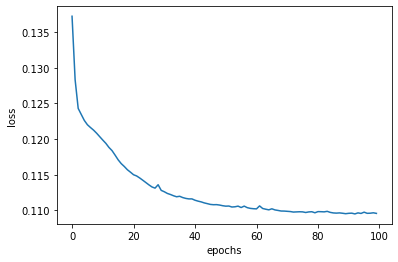

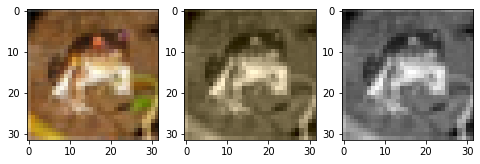

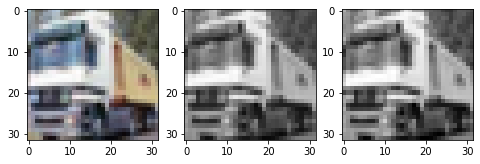

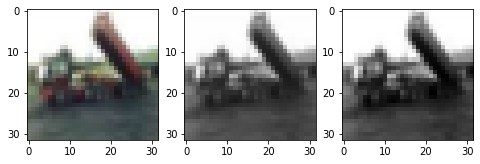

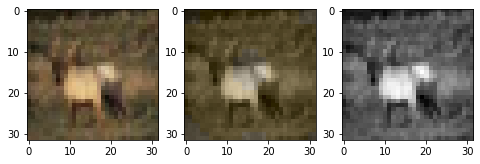

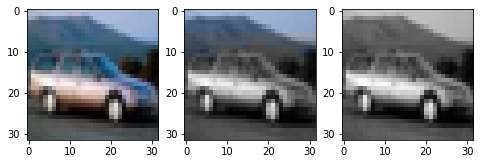

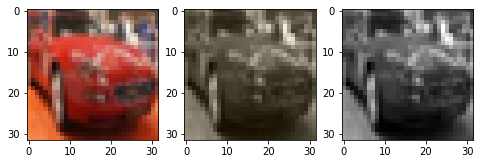

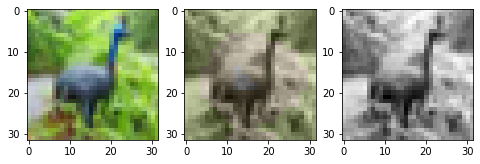

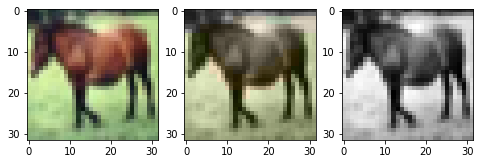

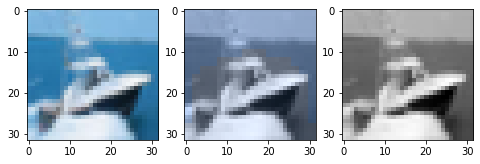

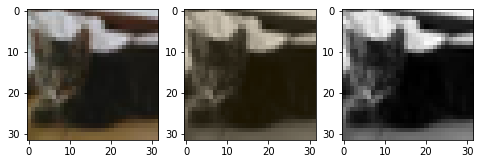

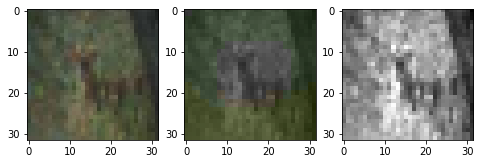

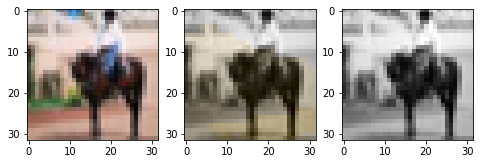

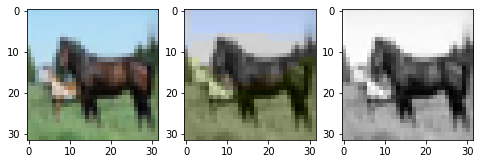

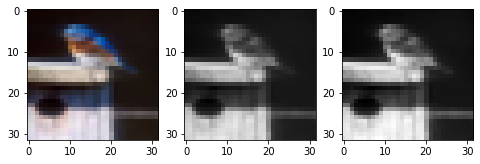

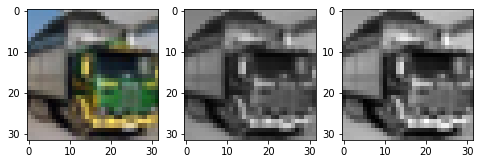

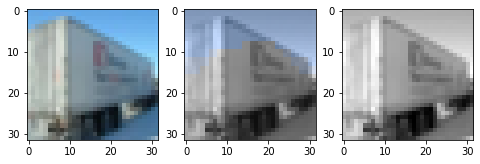

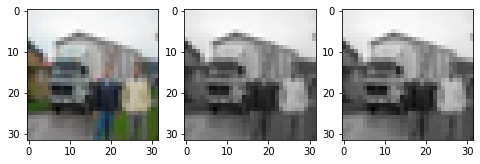

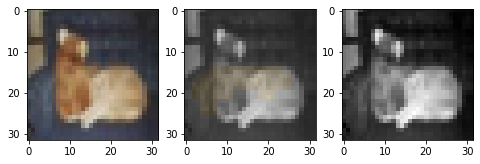

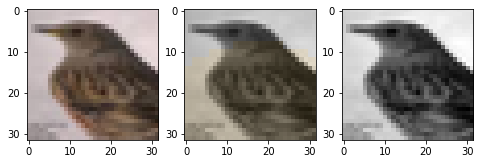

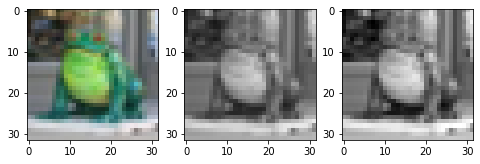

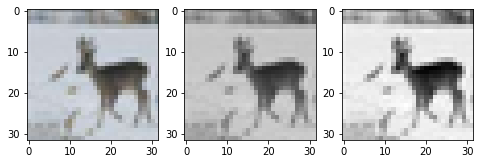

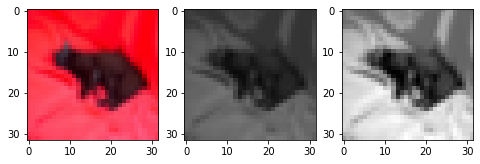

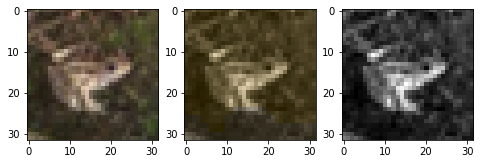

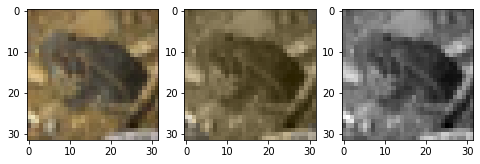

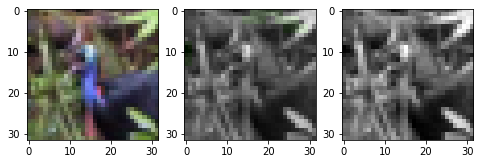

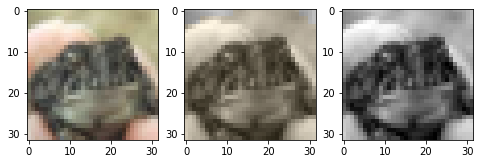

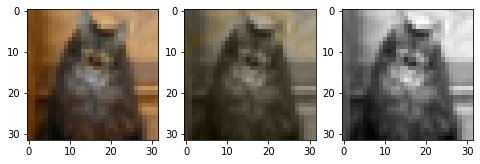

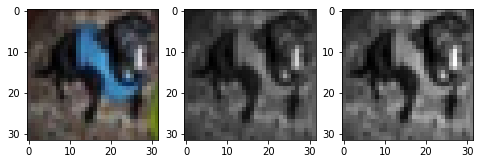

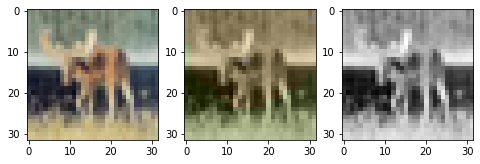

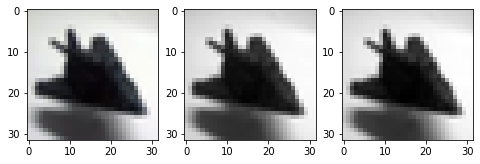

In [3]:
#Code to run here:

in_shape = (32, 32, 1)  # input shape
k_size = 3  # kernel_size
dil_rate = 2  # dilation
fact = 1
pad = 'same'  # padding

save_rate = 1000  # Rate at which to save intermediate results
num_images = 50000  # number of images to train with
TEMPERATURE = 0.38  # CONSTANT FOR ANNEALED MEAN
epochs = 100
#Data for training
gray_imgs, color_imgs = get_gray_rgb_imgs(num_images)
ab_imgs, one_hot_truth, quantized_ab = get_ab_imgs(color_imgs)

num_bins = quantized_ab.shape[0]

#loss function to use:
loss = loss_classification
#Call main(). it is inside this guard since it multiprocessing can be utilized to increase performance
if __name__ == '__main__':
    main()


In [ ]:
# Make simple weight vector for the ab space

color_imgs = load_all()
color_imgs = color_imgs.reshape((color_imgs.shape[0], 32, 32, 3), order='F').swapaxes(1, 2).astype('uint8')
ab_imgs = rgb2lab(color_imgs)[:, :, :, 1:]

ab_imgs_round = np.around(ab_imgs, decimals=-1)
ab_space = np.unique(ab_imgs_round.reshape(-1, 2), axis=0)
quantized = np.zeros((ab_imgs_round.shape[0], ab_imgs_round.shape[1], ab_imgs_round.shape[2], 1))

for i, img in enumerate(ab_imgs_round):
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            pixel_diff = np.abs(ab_space - img[x,y])
            mean_diff = np.mean(pixel_diff, axis=1)
            closest_bin_idx = np.argmin(mean_diff)
            quantized[i,x,y] = closest_bin_idx
    if i % 100 == 0:
        print("Processed {}".format(i))

bin_indices, bin_counts = np.unique(quantized, return_counts=True)

counts_inv = 1. / bin_counts

counts_normalized = counts_inv / np.sum(counts_inv)

np.save('ab_space_weights', counts_normalized)